In [22]:
""" Youtube Dataset
1. Transcripts auto-gen vs. manual
2. Num speakers
3. Total hours (h)
4. Languages (only german)
5. Genre / Topics
6. Sampling rate
7. Bit rate
8. Length distribution
9. Unique words used (vocab size)
10. Average words per minute

"""

' Youtube Dataset\n1. Transcripts auto-gen vs. manual\n2. Num speakers\n3. Total hours (h)\n4. Languages (only german)\n5. Genre / Topics\n6. Sampling rate\n7. Bit rate\n8. Length distribution\n9. Unique words used (vocab size)\n10. Average words per minute\n\n'

In [23]:
import os
from collections import defaultdict

import pandas as pd
import torch
import torchaudio as ta
from data_utils import SpeechDataset, filter_yt_df, yt_data_to_df
from eval_utils import _normalize_text, _wer
from IPython.display import Audio
from tqdm import tqdm

In [24]:
video_dir = r"D:\Personal\OneDrive\Gabrilyi\SPEECH2TEXT\2024_STT"
if not os.path.exists(video_dir):
    print('Video directory not found')
    raise FileNotFoundError(video_dir)
    
cache_dir = './cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

In [25]:
# yt_df, video_df, segment_df = yt_data_to_df(video_dir, do_load_transcripts=True)

In [26]:
YT_DF_PATH = r"D:\Personal\OneDrive\Gabrilyi\SPEECH2TEXT\yt_df.parquet"
SEGMENT_DF_PATH = r"D:\Personal\OneDrive\Gabrilyi\SPEECH2TEXT\segment_df.parquet"
VIDEO_DF_PATH = r"D:\Personal\OneDrive\Gabrilyi\SPEECH2TEXT\video_df.parquet"

yt_df = pd.read_parquet(YT_DF_PATH)
segment_df = pd.read_parquet(SEGMENT_DF_PATH)
video_df = pd.read_parquet(VIDEO_DF_PATH)

target_sr = 16000

In [28]:
# # Plot using Seaborn
# samplingrates = defaultdict(int)
# fails = []
# for audio_path in segment_df["segment_path"]:
#     try:
#         audio, sr = ta.load(audio_path)
#         samplingrates[sr] += 1
#     except Exception as e:
#         fails.append((audio_path, e))
    
    
# import seaborn as sns
# import matplotlib.pyplot as plt

# samplingrates_df = pd.DataFrame(list(samplingrates.items()), columns=['Sampling Rate', 'Count'])
# plt.figure(figsize=(10, 6))
# sns.barplot(x='Sampling Rate', y='Count', data=samplingrates_df)
# plt.title('Sampling Rate Distribution')
# plt.xlabel('Sampling Rate')
# plt.ylabel('Count')
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# plt.show()

# # All 44100

In [29]:
# Num Videos
num_videos = yt_df['video_id'].nunique()
print(f'Num Videos: {num_videos}')

Num Videos: 1820


In [30]:
len(yt_df.groupby('is_generated')['video_id'].value_counts()[True]), len(yt_df.groupby('is_generated')['video_id'].value_counts()[False])

(1040, 780)

In [31]:
print(f"Original number of segments: {len(yt_df)}")
print(f'Number of german segments: {len(yt_df[yt_df.language == "de"])}')
print(f'Number of english segments: {len(yt_df[yt_df.language == "en"])}')
print(f"Number of auto generated segments: {len(yt_df[yt_df.is_generated == True])}")
print(f"Number of manual segments: {len(yt_df[yt_df.is_generated == False])}")
print(f"Total duration: {yt_df.segment_duration.sum() / 3600:.2f}h")
print(f"Total duration (manual): {yt_df[yt_df.is_generated == False].segment_duration.sum() / 3600:.2f}h")
print(f"Valid audio segments: {yt_df[yt_df.valid_audio].count().segment_id} / {len(yt_df)}")
min_segment_length = None
max_segment_length = 30
target_language = "de"
use_auto_generated = False
min_words = None
max_words = None
drop_columns = ["language", "is_generated", "num_segments", "segment_durations", "segment_id", "valid_audio"]
yt_df_filtered = filter_yt_df(
    yt_df,
    min_segment_length=min_segment_length,
    max_segment_length=max_segment_length,
    language=target_language,
    use_auto_generated=use_auto_generated,
    min_words=min_words,
    max_words=max_words,
)
yt_df_filtered = yt_df_filtered[yt_df_filtered.valid_audio].reset_index(drop=True)
print(f"Filtered number of segments: {len(yt_df_filtered)}")
print(f"Total duration: {yt_df_filtered.segment_duration.sum() / 3600:.2f}h")
print(f'Number of unique videos: {yt_df_filtered.video_id.nunique()}')
yt_df_filtered = yt_df_filtered.drop(columns=drop_columns)
yt_df_filtered.head(3)  

Original number of segments: 28522
Number of german segments: 27612
Number of english segments: 178
Number of auto generated segments: 15815
Number of manual segments: 12707
Total duration: 164.70h
Total duration (manual): 75.17h
Valid audio segments: 28521 / 28522
Filtered number of segments: 11839
Total duration: 68.59h
Number of unique videos: 733


video_id                                         video_path  \
0  -3sWj2tYFe4  D:\Personal\OneDrive\Gabrilyi\SPEECH2TEXT\2024...   
1  -3sWj2tYFe4  D:\Personal\OneDrive\Gabrilyi\SPEECH2TEXT\2024...   
2  -3sWj2tYFe4  D:\Personal\OneDrive\Gabrilyi\SPEECH2TEXT\2024...   

                                     video_url  \
0  https://www.youtube.com/watch?v=-3sWj2tYFe4   
1  https://www.youtube.com/watch?v=-3sWj2tYFe4   
2  https://www.youtube.com/watch?v=-3sWj2tYFe4   

                                        segment_path  \
0  D:\Personal\OneDrive\Gabrilyi\SPEECH2TEXT\2024...   
1  D:\Personal\OneDrive\Gabrilyi\SPEECH2TEXT\2024...   
2  D:\Personal\OneDrive\Gabrilyi\SPEECH2TEXT\2024...   

                                     transcript_path  segment_duration  \
0  D:\Personal\OneDrive\Gabrilyi\SPEECH2TEXT\2024...             19.52   
1  D:\Personal\OneDrive\Gabrilyi\SPEECH2TEXT\2024...             20.64   
2  D:\Personal\OneDrive\Gabrilyi\SPEECH2TEXT\2024...             19.36   

                                          transcript  num_words  
0  der sich alles selbst erarbeitet hat, lässt ei...         56  
1  Elon Musk. Tesla, SpaceX, Twitter. Einer der d...         39  
2  und sich mit verschiedenen Jobs über Wasser hä...         52

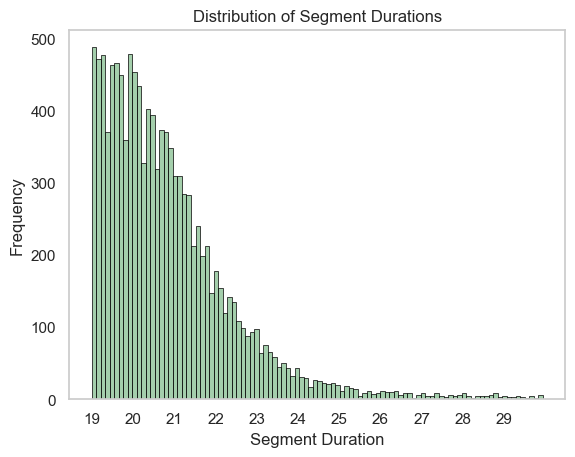

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming yt_df_filtered is your DataFrame containing the data
sns.set(style="whitegrid")  # Setting the style

# Creating the histogram
sns.histplot(data=yt_df_filtered, x='segment_duration', bins=100, color='#86bf91', linewidth=0.5, edgecolor='black')

# Customizing the plot
plt.xlabel('Segment Duration')
plt.ylabel('Frequency')
plt.title('Distribution of Segment Durations')
plt.xticks([i for i in range(int(min(yt_df_filtered.segment_duration)), int(max(yt_df_filtered.segment_duration)) + 1, 1)])
plt.grid(False)

# Showing the plot
plt.show()


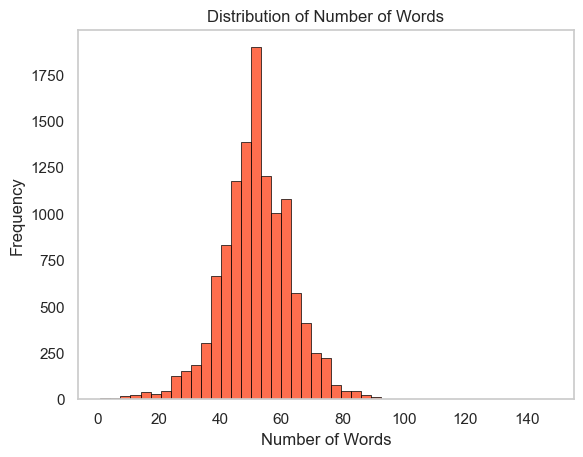

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming yt_df_filtered is your DataFrame containing the data
sns.set(style="whitegrid")  # Setting the style

# Creating the histogram
sns.histplot(data=yt_df_filtered, x='num_words', bins=45, color='#fe3e12', linewidth=0.5, edgecolor='black')

# Customizing the plot
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Words')
plt.grid(False)

# Showing the plot
plt.show()


In [ ]:
def count_words(text):
    return len(text.split())

# Calculate total number of words
total_words = yt_df_filtered['transcript'].apply(count_words).sum()

# Calculate total duration in minutes
total_duration_minutes = yt_df_filtered['segment_duration'].sum() / 60

# Calculate average words per minute
avg_words_per_minute = total_words / total_duration_minutes

print("Average words per minute:", avg_words_per_minute)

Average words per minute: 147.65513751635194


In [ ]:
# load a random audio file
sample_segment = yt_df_filtered.sample(1).iloc[0]
audio_file_path = sample_segment['segment_path']
transcript = sample_segment['transcript']
wave, sr = ta.load(audio_file_path)
print(f'Loaded audio file: {audio_file_path}')
print(f'Wave shape: {wave.shape}')
print(f'Sample rate: {sr}')
display(Audio(wave.numpy(), rate=sr))

res_wave = ta.transforms.Resample(sr, target_sr)(wave)
print(f'Wave shape after resampling: {res_wave.shape}')
display(Audio(res_wave.numpy(), rate=target_sr))

# show the transcript but only x words per line
words = transcript.split()
words_per_line = 15
for i in range(0, len(words), words_per_line):
    print(' '.join(words[i:i+words_per_line]))

Loaded audio file: D:\Personal\OneDrive\Gabrilyi\SPEECH2TEXT\2024_STT\6yHR8x7JwSo\segments\segment_06.mp3
Wave shape: torch.Size([1, 873180])
Sample rate: 44100


Wave shape after resampling: torch.Size([1, 316800])


wie ich mir das vielleicht wünschen würde. Ich habe meine Mutterschaft bereut und das ist
jetzt nicht mehr so, aber es gibt eine Zeit, die ich erlebt habe, als ich
alleinerziehend war, mit ihr. Magst du das mal ein bisschen beschreiben, wie sich das anfühlt,
die Mutterschaft zu bereuen? Ja, also ich war damals


In [33]:
import pandas as pd
import torchtext
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer("basic_english")

# Function to tokenize content and update global vocabulary
def process_transcript(transcript_path):
    with open(transcript_path, 'r', encoding='utf-8') as file:
        content = file.read()
        tokens = tokenizer(content)
    return tokens



# Initialize global vocabulary set


results = [process_transcript(row['transcript_path']) for index, row in yt_df.iterrows()]

o:\Programs\Python\3_11_6\Lib\site-packages\torchtext\data\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [34]:
global_vocab = defaultdict(int)
# Results to Vocab
for result in results:
    for token in result:
        global_vocab[token] += 1


# Print global vocabulary
print("Global Vocabulary:")
print(global_vocab)
# save as json
import json
with open('vocab.json', 'w') as file:
    json.dump(global_vocab, file)

Global Vocabulary:
defaultdict(<class 'int'>, {'das': 27716, 'stelle': 264, 'ich': 21628, 'hier': 3803, 'ausdrücklich': 15, 'fest': 188, 'nur': 4714, 'gut': 1966, 'dass': 11019, 'können': 2237, 'parteispenden': 2, 'auch': 14589, 'sein': 3116, 'hat': 8836, 'er': 6378, 'bislang': 49, 'komischerweise': 8, 'in': 20264, 'keiner': 225, 'rede': 116, 'wirklich': 1942, 'thematisiert': 16, 'aber': 9389, 'am': 2446, 'rande': 14, 'besonders': 615, 'angst': 426, 'davor': 118, 'vermehrte': 2, 'einwanderung': 14, 'ende': 838, 'richtig': 1180, 'ins': 688, 'geld': 1135, 'gehen': 933, 'könnte': 1033, 'sozialstaat': 6, 'und': 41174, 'offene': 36, 'grenzen': 121, 'kann': 4875, 'niemals': 141, 'zusammen': 533, 'funktionieren': 134, 'ist': 22120, 'ungefähr': 205, 'so': 12603, 'als': 6542, 'wenn': 6461, 'man': 8687, 'im': 6994, 'winter': 51, 'sie': 9220, 'befördern': 11, 'jeder': 669, 'rest': 109, 'seiner': 732, 'fraktion': 47, 'deshalb': 703, 'entschieden': 128, 'der': 26964, 'gegner': 65, 'energiewende': 2

Plotting...


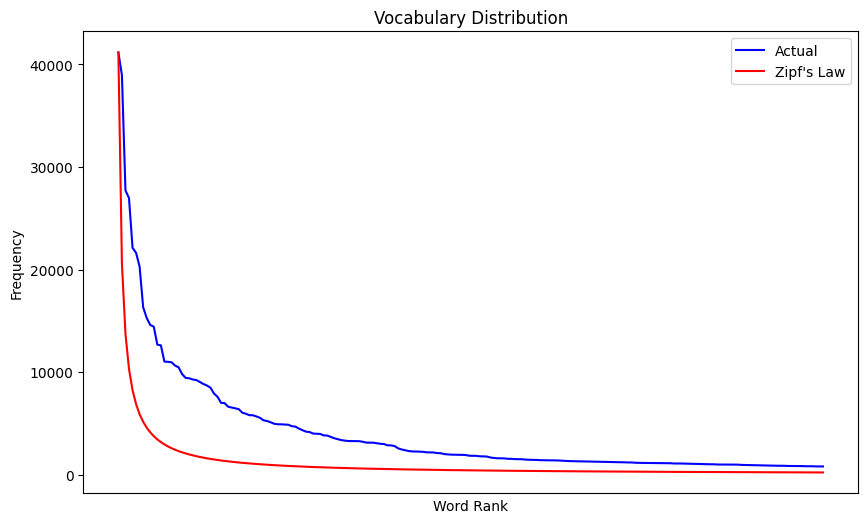

Plotting...


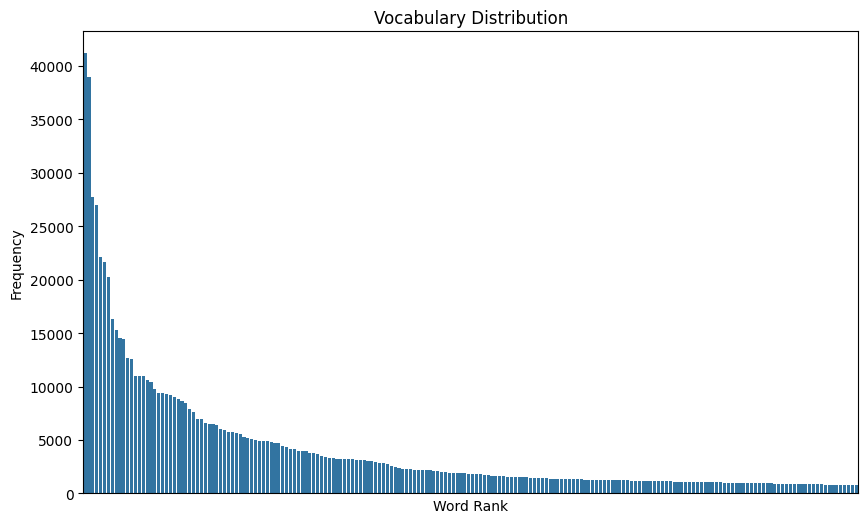

In [35]:
# Sort vocabulary by frequency
sorted_vocab = sorted(global_vocab.items(), key=lambda x: x[1], reverse=True)
# Delete punctuation tokens
sorted_vocab = [(token, freq) for token, freq in sorted_vocab if token.isalnum()]

import seaborn as sns
import matplotlib.pyplot as plt

# Convert sorted_vocab to separate lists for tokens and frequencies
tokens, frequencies = zip(*sorted_vocab)

# Create a DataFrame for plotting

vocab_df = pd.DataFrame({'Token': tokens, 'Frequency': frequencies}).head(200)
ranks = list(range(1, len(vocab_df) + 1))
zipf_freqs = [frequencies[0] / r for r in ranks]
print("Plotting...")
# Plot using Seaborn
plt.figure(figsize=(10, 6))
# sns.barplot(x='Token', y='Frequency', data=vocab_df)
sns.lineplot(x=ranks, y=vocab_df["Frequency"], color='blue', label='Actual')
sns.lineplot(x=ranks, y=zipf_freqs, color='red', label='Zipf\'s Law')
plt.title('Vocabulary Distribution')
plt.xticks([])
plt.xlabel('Word Rank')
plt.ylabel('Frequency')
plt.show()

print("Plotting...")
# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Token', y='Frequency', data=vocab_df)
plt.title('Vocabulary Distribution')
plt.xticks([])
plt.xlabel('Word Rank')
plt.ylabel('Frequency')
plt.show()

In [36]:
channel_dir = r"../datasynth/channel_videos"

channel_files = [os.path.join(channel_dir, f) for f in os.listdir(channel_dir)]

channel_files

vid_dict = defaultdict(str)
vids = []
for f in channel_files:    
    with open(f, 'r', encoding='utf-8') as file:
        content = file.read().split('\n')
        for vid in content:
            vids.append(vid)
            vid_dict[vid] = os.path.basename(f).split('.')[0]

In [37]:
len(vids)

1692

In [38]:
# Create a DataFrame from the dictionary where each row is a vid with its channel
channel_df = pd.DataFrame(vid_dict.items(), columns=['VID', 'Channel'])

In [39]:
channel_df

VID           Channel
0     qSXPKjWKoX4        atlas_funk
1     H61ruDYz34s        atlas_funk
2     f_VBR6ZoVu8        atlas_funk
3     MFAeEnpyf24        atlas_funk
4     tyXr8jDaDCw        atlas_funk
...           ...               ...
1609  FOo4sZx-NDU  waskostetdiewelt
1610  Tywmjv1fHu0  waskostetdiewelt
1611  KKw48FqoK-4  waskostetdiewelt
1612  zp7XvkpppLI  waskostetdiewelt
1613  BfYzwUk6X5M  waskostetdiewelt

[1614 rows x 2 columns]

In [40]:
yt_df_filtered['channel'] = yt_df_filtered['video_id'].map(channel_df.set_index('VID')['Channel'])

In [59]:
yt_df_filtered.groupby('channel')['video_id'].nunique()

channel
atlas_funk            9
chrismuellerr        15
derbiograph         115
derfall              69
diedaoben            65
funk-misc             3
germania             41
glanzundnatur        12
maithinkx           136
simplicissimus       75
sonnetodsterne       23
terraxplore          75
unbubble             83
waskostetdiewelt     10
Name: video_id, dtype: int64

In [60]:
yt_df_videos_by_channel = pd.DataFrame(yt_df_filtered.groupby('channel')['video_id'].nunique())
yt_df_videos_by_channel = yt_df_videos_by_channel.reset_index()
num_speakers = [2,43,1,283,133,12,41,3,1,77,1,525,581,23]

yt_df_videos_by_channel['num_speakers'] = num_speakers

yt_df_videos_by_channel

channel  video_id  num_speakers
0         atlas_funk         9             2
1      chrismuellerr        15            43
2        derbiograph       115             1
3            derfall        69           283
4          diedaoben        65           133
5          funk-misc         3            12
6           germania        41            41
7      glanzundnatur        12             3
8          maithinkx       136             1
9     simplicissimus        75            77
10    sonnetodsterne        23             1
11       terraxplore        75           525
12          unbubble        83           581
13  waskostetdiewelt        10            23

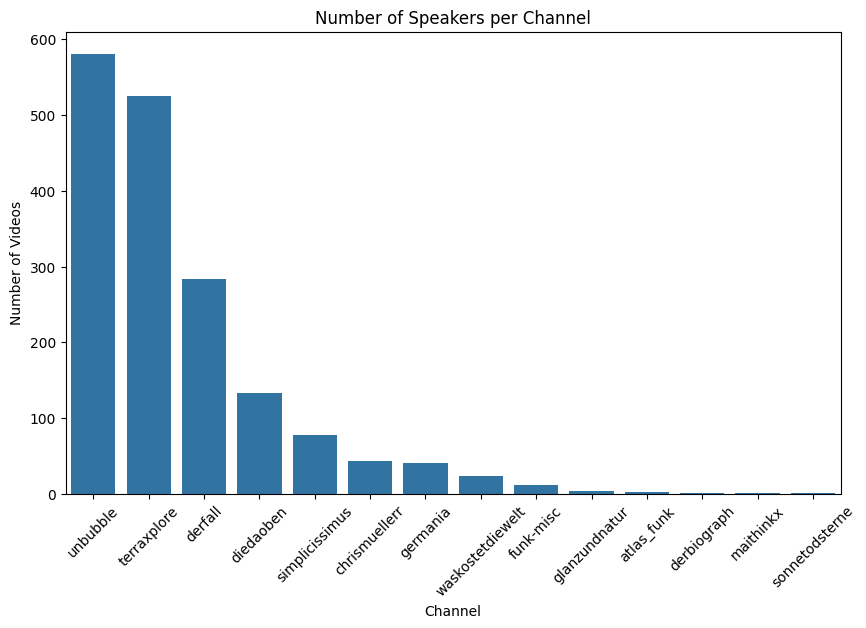

In [62]:
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='channel', y='num_speakers', data=yt_df_videos_by_channel, order=yt_df_videos_by_channel.sort_values('num_speakers', ascending=False).channel)
plt.title('Number of Speakers per Channel')
plt.xlabel('Channel')
plt.ylabel('Number of Videos')
plt.xticks(rotation=45)
plt.show()


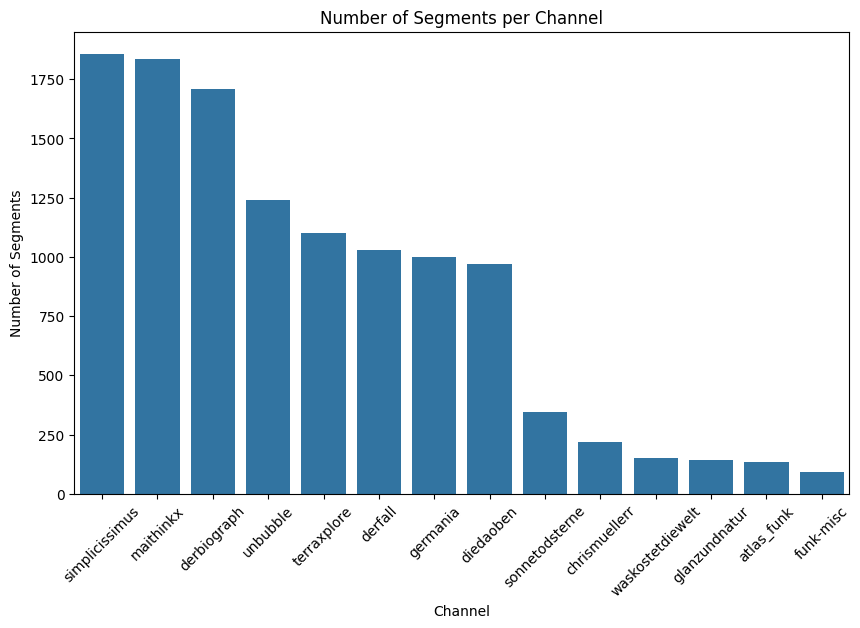

In [56]:
# Plot
plt.figure(figsize=(10, 6))
sns.countplot(data=yt_df_filtered, x='channel', order=yt_df_filtered['channel'].value_counts().index)
plt.title('Number of Segments per Channel')
plt.xlabel('Channel')
plt.ylabel('Number of Segments')
plt.xticks(rotation=45)
plt.show()